# Evidence for optional stopping

In [1]:
import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "jax"

import matplotlib.pyplot as plt
import numpy as np

import keras
import bayesflow as bf
import pandas as pd

In this example we will evaluate the evidence that the results of the 9
studies presented by Bem et al. (2011) are contaminated by optional
stopping.

### Simulator

The generative model is same as in the example on Pearson’s correlation,
though in this case we make two variants: `null` and `alternative`
models. Under the null model, $\rho$ is held fixed at zero, whereas
under the alternative model, $\rho \sim \text{Uniform}(-1, 1)$.

To generalize the procedure to different sample sizes, we will vary $n$
between 3 and 20.

Note that we change the prior model probability of the null model to 0.8
(and correspondingly of the alternative model to 0.2). The null model
doesn’t generate many extreme correlations (i.e., correlations close to
-1 and 1). Increasing the prior model probability ensures that the
trainer has enough examples of the sampling distribution under the null
model in the tails.

In [8]:
def context(batch_size):
    return dict(n = np.random.randint(3, 21))

def prior_null():
    return dict(rho=0)

def prior_alternative():
    return dict(rho=np.random.uniform(low=-1, high=1))

def likelihood(rho, n):
    y = np.random.multivariate_normal(mean=[0, 0], cov = [[1,rho], [rho,1]], size=n)
    r = np.corrcoef(y, rowvar=False)[0,1]
    return dict(r=r)

simulator = bf.simulators.ModelComparisonSimulator(
    simulators=[
        bf.make_simulator([prior_null, likelihood]),
        bf.make_simulator([prior_alternative, likelihood])
    ],
    shared_simulator=context,
    p = [0.8, 0.2]
)

### Approximator

We will use the model comparison approximator to compare the models. We
will use a simple MLP layer for the model classification.

In [15]:
adapter=(bf.Adapter()
    .broadcast("n", to="r")
    .concatenate(["n", "r"], into="classifier_conditions")
    .drop("rho")
)

In [16]:
classifier_network = keras.Sequential([keras.layers.Dense(32, activation="gelu") for _ in range(6)])
approximator=bf.approximators.ModelComparisonApproximator(
    num_models=2,
    classifier_network=classifier_network,
    adapter=adapter
)

### Training

In [ ]:
epochs=20
batches=100
batch_size=512
schedule=keras.optimizers.schedules.CosineDecay(1e-5, decay_steps=epochs*batches)
optimizer=keras.optimizers.Adam(schedule)
approximator.compile(optimizer)

In [ ]:
history=approximator.fit(
    epochs=epochs, 
    num_batches=batches, 
    batch_size=batch_size,
    adapter=adapter, 
    simulator=simulator)

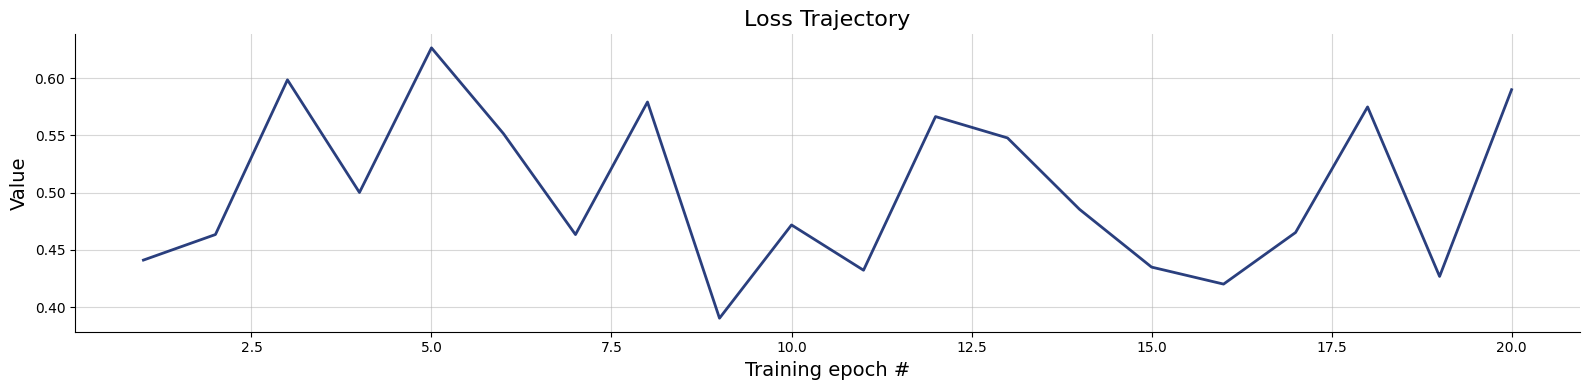

In [19]:
fig=bf.diagnostics.plots.loss(history)

### Validation

In [20]:
test_data = simulator.sample(10_000)
true_models = test_data['model_indices']
pred_models = approximator.predict(conditions=test_data)

INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode

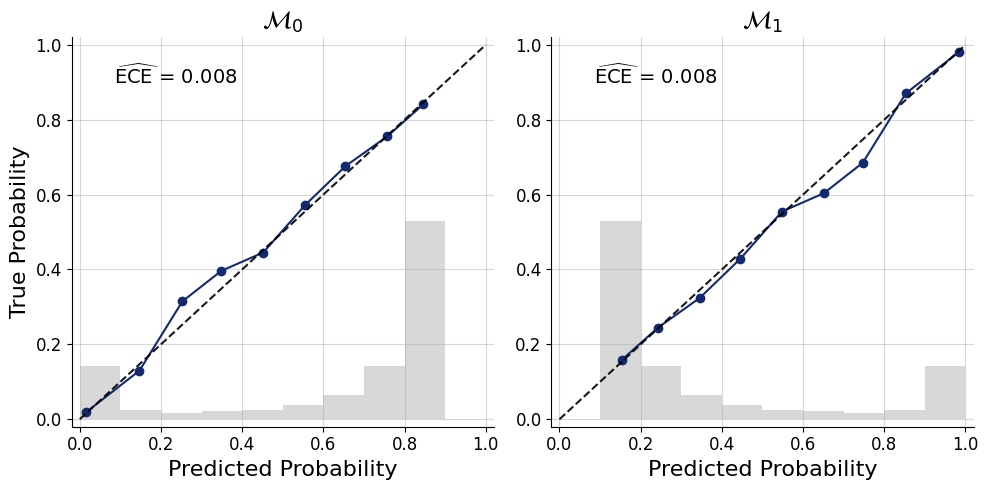

In [24]:
f=bf.diagnostics.plots.mc_calibration(
    pred_models=pred_models,
    true_models=true_models,
    model_names=[r"$\mathcal{M}_0$",r"$\mathcal{M}_1$"]
)

INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol M from STIXNonUnicode

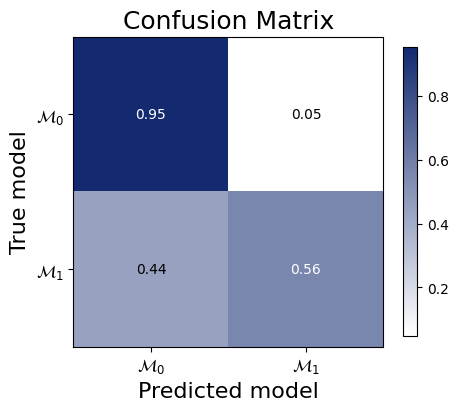

In [25]:
f=bf.diagnostics.plots.mc_confusion_matrix(
    pred_models=pred_models,
    true_models=true_models,
    normalize="true",
    model_names=[r"$\mathcal{M}_0$",r"$\mathcal{M}_1$"]
)

### Inference

Now that we have trained the network, we can compute the Bayes factor in
favuor of the model that posits that there is a correlation between the
effect size and sample size.

Recall that we increased the prior model probability of the null model
to 0.8. This means that in order to calculate the Bayes factor in favour
of the alternative model, we must divide the posterior odds with the
prior odds.

In [30]:
inference_data = dict(
    n = np.array([[9]]),
    r = np.array([[-0.8717038]])
)
posterior_model_probs = approximator.predict(conditions=inference_data)[0]

posterior_model_odds_10 = posterior_model_probs[1] / posterior_model_probs[0]
prior_model_odds_10 = 0.2 / 0.8
bf_10 = posterior_model_odds_10 / prior_model_odds_10
bf_10

59.72677230834961

$\text{BF}_{10} \approx 60$ provides evidence for optional stopping.

Note: The results here are only approximate and differ from the original
analysis by about a factor of 3. This is because the classification
network cannot extrapolate well for such an extreme correlation (from
the perspective of the null model).